# GMM Project

### Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [3]:
# Loading the data
df = pd.read_csv('../data/Bus77_Load.csv')
df.head()

,Load(MW)
0,0.7283
1,1.3353
2,4.3548
3,1.6287
4,3.9702


In [4]:
# Check for missing values
print(df.isnull().sum())

Load(MW)    0
dtype: int64


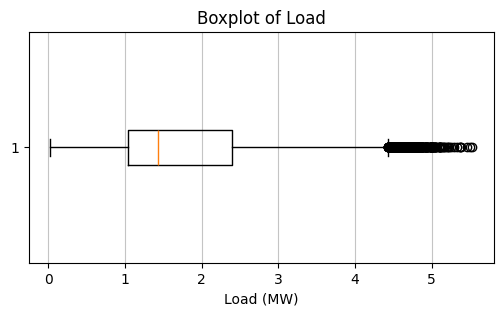

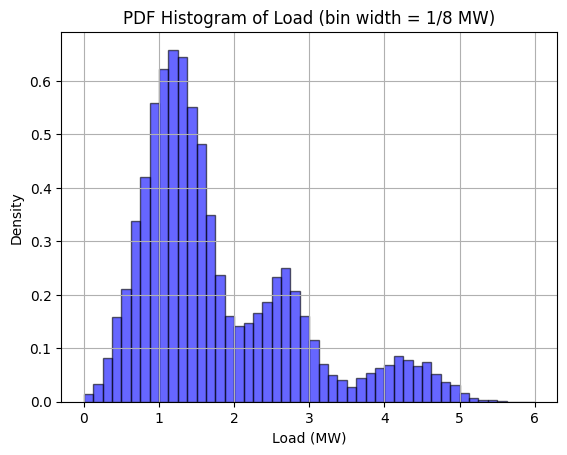

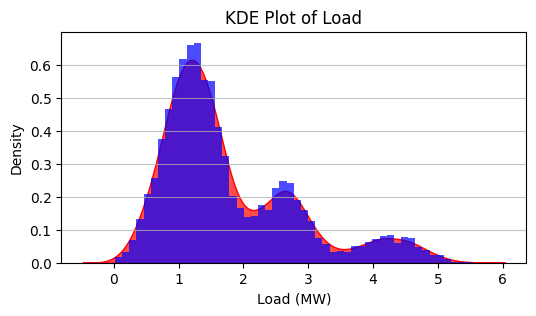

In [5]:
# Boxplot of the load
plt.figure(figsize=(6, 3))
plt.boxplot(df['Load(MW)'], vert=False)
plt.title('Boxplot of Load')
plt.xlabel('Load (MW)')
plt.grid(axis='x', alpha=0.75)
plt.savefig('../results/Bus77_Load_Boxplot.png', dpi=300)
plt.show()

# The box plot shows there might be some outliers in the data. Let us chekk the histogram to see the distribution of the load.

# Histogram of the load
data = df['Load(MW)'].values

# Define bin edges with interval width = 0.125
bin_edges = np.arange(start=np.floor(min(data)), 
                      stop=np.ceil(max(data)) + 0.125, 
                      step=0.125)

# Plot histogram as a PDF
plt.hist(data, bins=bin_edges, density=True, color='blue', alpha=0.6, edgecolor='black')
plt.xlabel("Load (MW)")
plt.ylabel("Density")
plt.title("PDF Histogram of Load (bin width = 1/8 MW)")
plt.grid(True)
plt.show()


# The histogram shows that there are three peaks in the data. This is an indication that the data might be multimodal. Let us check the distribution of the load using a kernel density estimate (KDE) plot.

# KDE plot of the load
plt.figure(figsize=(6, 3))
sns.kdeplot(df['Load(MW)'], color='red', fill=True, alpha=0.7)
plt.hist(df['Load(MW)'], bins=50, density=True, color='blue', alpha=0.7)
plt.title('KDE Plot of Load')
plt.xlabel('Load (MW)')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)
plt.savefig('../results/Bus77_Load_KDE.png', dpi=300)
plt.show()

# The KDE plot shows that the data is multimodal. This is an indication that the data might be generated from a mixture of distributions.

### Choice of optimal K
#### K-means

Let:

- $X = \{x_1, x_2, \dots, x_N\} $ be your dataset  
- $ C_k $ be the set of data points assigned to cluster $ k $  
- $ \mu_k $ be the centroid (mean) of cluster $ C_k $  
- $ K $ be the number of clusters  

Then, the **inertia** is computed as:


$ Inertia = \sum_{k=1}^{K} \sum_{x_i \in C_k} \| x_i - \mu_k \|^2$


This is the sum of **squared Euclidean distances** between each point and the centroid of its assigned cluster for all $ K $ clusters.


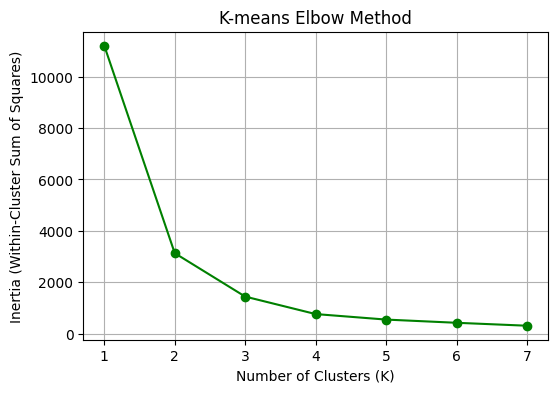

In [8]:
from sklearn.cluster import KMeans

data = df['Load(MW)'].values.reshape(-1, 1)

kmeans_inertia = []

# Try values of K from 1 to 7
ks = list(range(1, 8))

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(data)
    kmeans_inertia.append(kmeans.inertia_)  # sum of squared distances to cluster centers

# Plot K-means Elbow
plt.figure(figsize=(6, 4))
plt.plot(ks, kmeans_inertia, marker='o', color='green')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("K-means Elbow Method")
plt.grid(True)
plt.show()


#### Bayesian Information Criterion

The Bayesian Information Criterion (BIC) is given by:

$$
\text{BIC} = -2 \cdot \log L + p \cdot \log N
$$

Where:

- $ \log L $ = log-likelihood of the model  
- $ p $ = number of free parameters in the GMM  
- $ N $ = number of data points



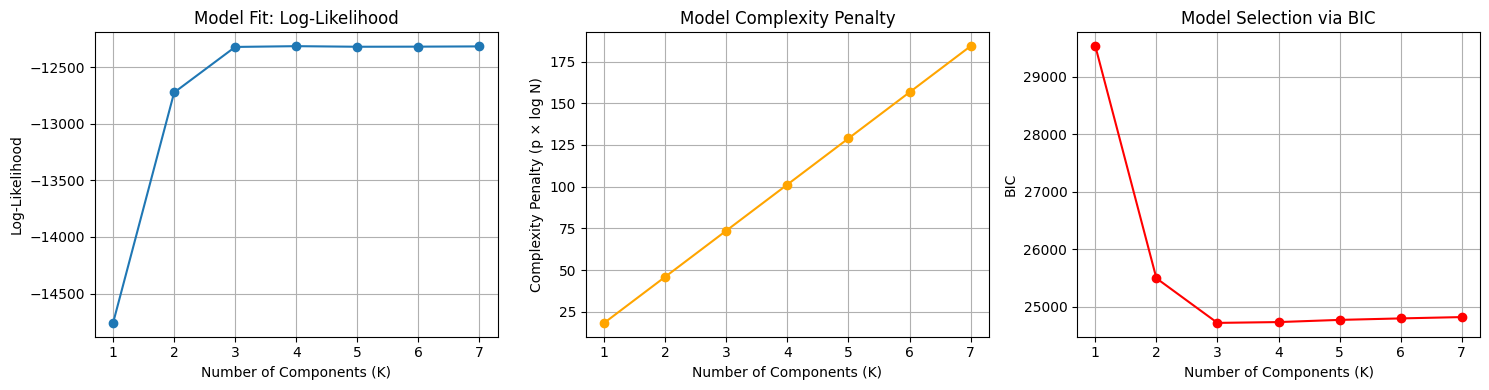

In [9]:
from sklearn.mixture import GaussianMixture

log_likelihoods = []
bics = []

n = len(data)
complexity_penalty = []

for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data)
    
    log_likelihood = gmm.score(data) * n
    p = gmm._n_parameters()  # number of free parameters
    penalty = p * np.log(n)
    
    log_likelihoods.append(log_likelihood)
    bics.append(-2 * log_likelihood + penalty)
    complexity_penalty.append(penalty)


plt.figure(figsize=(15, 4))

# Log-Likelihood
plt.subplot(1, 3, 1)
plt.plot(ks, log_likelihoods, marker='o')
plt.xticks(ks)
plt.xlabel("Number of Components (K)")
plt.ylabel("Log-Likelihood")
plt.title("Model Fit: Log-Likelihood")
plt.grid(True)

# Complexity penalty
plt.subplot(1, 3, 2)
plt.plot(ks, complexity_penalty, marker='o', color='orange')
plt.xticks(ks)
plt.xlabel("Number of Components (K)")
plt.ylabel("Complexity Penalty (p × log N)")
plt.title("Model Complexity Penalty")
plt.grid(True)

# BIC
plt.subplot(1, 3, 3)
plt.plot(ks, bics, marker='o', color='red')
plt.xticks(ks)
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC")
plt.title("Model Selection via BIC")
plt.grid(True)

plt.tight_layout()
plt.show()

### Fitting Base GMM Model

In [51]:
from sklearn.mixture import GaussianMixture
import time
from sklearn.cluster import KMeans
from scipy.stats import norm

# Prepare data
X = df['Load(MW)'].values.reshape(-1, 1)
n_samples = len(X)
K = 3

# Extractinng initial estimates for the parameters

# K-means initialization for initial guess
kmeans_init = KMeans(n_clusters=K, random_state=42, n_init=1)
cluster_labels_init = kmeans_init.fit_predict(X)

initial_weights = []
initial_means = []
initial_variances = []

for k in range(K):
    cluster_points = X[cluster_labels_init == k]
    N_k = len(cluster_points)
    initial_weights.append(N_k / len(X))
    initial_means.append(np.mean(cluster_points))
    initial_variances.append(np.var(cluster_points))


# Fit GMM with K = 3
gmm = GaussianMixture(n_components=K, random_state=42, n_init=1, init_params='kmeans')
# time counter
start_time = time.perf_counter()
gmm.fit(X)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Time taken to fit GMM with K = {K}: {elapsed_time:.4f} seconds")

# Get learned parameters
weights = gmm.weights_
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()
stds = np.sqrt(variances)

Time taken to fit GMM with K = 3: 0.0287 seconds


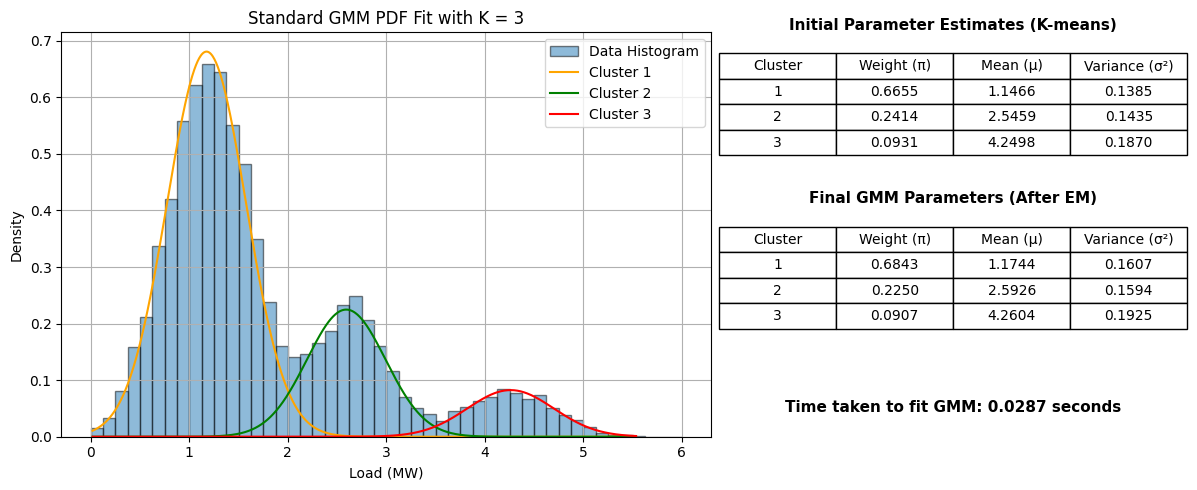

In [52]:
# Plotting

from matplotlib.gridspec import GridSpec

# Set up layout: 2 rows, 2 columns
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(3, 2, width_ratios=[2.5, 1.5], height_ratios=[2.5, 2.5, 1])

# --- LEFT: PDF Histogram and GMM Clusters ---
ax0 = fig.add_subplot(gs[:, 0])  # span both rows
bin_edges = np.arange(start=np.floor(min(X)), 
                      stop=np.ceil(max(X)) + 0.125, 
                      step=0.125)
ax0.hist(X.flatten(), bins=bin_edges, density=True, alpha=0.5, edgecolor='black', label='Data Histogram')

x = np.linspace(min(X), max(X), 1000)
colors = ['orange', 'green', 'red']

for i in range(K):
    pdf = weights[i] * norm.pdf(x, means[i], stds[i])
    ax0.plot(x, pdf, label=f'Cluster {i+1}', color=colors[i])

ax0.set_xlabel("Load (MW)")
ax0.set_ylabel("Density")
ax0.set_title(f"Standard GMM PDF Fit with K = {K}")
ax0.legend()
ax0.grid(True)

# Set up right side for two stacked tables
ax1 = fig.add_subplot(gs[0, 1])
ax1.axis('off')

# ---- Initial Parameters Table ----
initial_table_data = [["Cluster", "Weight (π)", "Mean (μ)", "Variance (σ²)"]]
for i in range(K):
    row = [f"{i+1}",
           f"{initial_weights[i]:.4f}",
           f"{initial_means[i]:.4f}",
           f"{initial_variances[i]:.4f}"]
    initial_table_data.append(row)

# Title
ax1.text(0.5, 1.1, "Initial Parameter Estimates (K-means)",
         fontsize=11, ha='center', va = 'top', fontweight='bold')

# Draw initial table
table1 = ax1.table(cellText=initial_table_data, loc='center', cellLoc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1.2, 1.5)

# ---- Final Parameters Table (New axis below) ----
ax1b = fig.add_subplot(gs[1, 1])
ax1b.axis('off')

final_table_data = [["Cluster", "Weight (π)", "Mean (μ)", "Variance (σ²)"]]
for i in range(K):
    row = [f"{i+1}",
           f"{weights[i]:.4f}",
           f"{means[i]:.4f}",
           f"{variances[i]:.4f}"]
    final_table_data.append(row)

# Title
ax1b.text(0.5, 1.1, "Final GMM Parameters (After EM)",
          fontsize=11, ha='center',  va = 'top', fontweight='bold')

# Draw final table
table2 = ax1b.table(cellText=final_table_data, loc='center', cellLoc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1.2, 1.5)

#Runtime Text
ax2 = fig.add_subplot(gs[2, 1])
ax2.axis('off')
ax2.text(0.5, 0.5, f"Time taken to fit GMM: {elapsed_time:.4f} seconds",
         ha='center', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("../results/standard_gmm_fit_with_table.png", dpi=300, bbox_inches='tight')
plt.show()

### Improved GMM

- Faster EM

In [53]:
from sklearn.mixture import GaussianMixture
import time

# Config: Lower precision, early stop, fewer iterations
gmm_fast_em = GaussianMixture(
    n_components=K,
    max_iter=30,          # fewer iterations
    tol=1e-2,             # early stopping tolerance
    n_init=1,             # single initialization
    init_params='kmeans', # smart starting point
    random_state=42
)

start_time = time.perf_counter()
gmm_fast_em.fit(X)
end_time = time.perf_counter()

# Calculate elapsed time

elapsed_time_fast_em = end_time - start_time

weights_fast_em = gmm_fast_em.weights_
means_fast_em = gmm_fast_em.means_.flatten()
variances_fast_em = gmm_fast_em.covariances_.flatten()
stds_fast_em = np.sqrt(variances_fast_em)


print(f"GMM with fast EM completed in {fast_em_elapsed:.4f} seconds.")


GMM with fast EM completed in 0.0254 seconds.


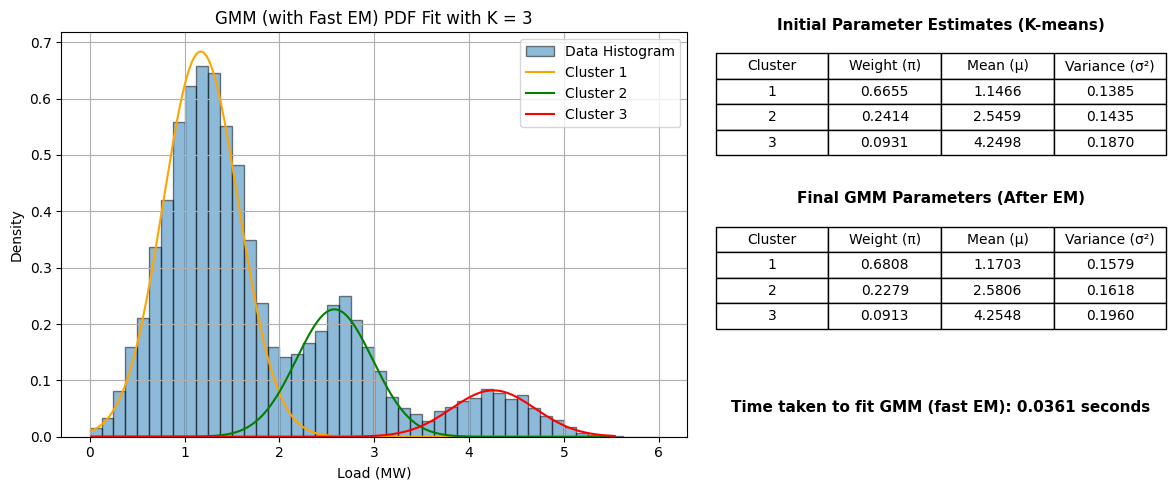

In [54]:
# Plotting

from matplotlib.gridspec import GridSpec

# Set up layout: 2 rows, 2 columns
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(3, 2, width_ratios=[2.5, 1.5], height_ratios=[2.5, 2.5, 1])

# --- LEFT: PDF Histogram and GMM Clusters ---
ax0 = fig.add_subplot(gs[:, 0])  # span both rows
bin_edges = np.arange(start=np.floor(min(X)), 
                      stop=np.ceil(max(X)) + 0.125, 
                      step=0.125)
ax0.hist(X.flatten(), bins=bin_edges, density=True, alpha=0.5, edgecolor='black', label='Data Histogram')

x = np.linspace(min(X), max(X), 1000)
colors = ['orange', 'green', 'red']

for i in range(K):
    pdf = weights_fast_em[i] * norm.pdf(x, means_fast_em[i], stds_fast_em[i])
    ax0.plot(x, pdf, label=f'Cluster {i+1}', color=colors[i])

ax0.set_xlabel("Load (MW)")
ax0.set_ylabel("Density")
ax0.set_title(f"GMM (with Fast EM) PDF Fit with K = {K}")
ax0.legend()
ax0.grid(True)

# Set up right side for two stacked tables
ax1 = fig.add_subplot(gs[0, 1])
ax1.axis('off')

# ---- Initial Parameters Table ----
initial_table_data = [["Cluster", "Weight (π)", "Mean (μ)", "Variance (σ²)"]]
for i in range(K):
    row = [f"{i+1}",
           f"{initial_weights[i]:.4f}",
           f"{initial_means[i]:.4f}",
           f"{initial_variances[i]:.4f}"]
    initial_table_data.append(row)

# Title
ax1.text(0.5, 1.1, "Initial Parameter Estimates (K-means)",
         fontsize=11, ha='center', va = 'top', fontweight='bold')

# Draw initial table
table1 = ax1.table(cellText=initial_table_data, loc='center', cellLoc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1.2, 1.5)

# ---- Final Parameters Table (New axis below) ----
ax1b = fig.add_subplot(gs[1, 1])
ax1b.axis('off')

final_table_data = [["Cluster", "Weight (π)", "Mean (μ)", "Variance (σ²)"]]
for i in range(K):
    row = [f"{i+1}",
           f"{weights_fast_em[i]:.4f}",
           f"{means_fast_em[i]:.4f}",
           f"{variances_fast_em[i]:.4f}"]
    final_table_data.append(row)

# Title
ax1b.text(0.5, 1.1, "Final GMM Parameters (After EM)",
          fontsize=11, ha='center',  va = 'top', fontweight='bold')

# Draw final table
table2 = ax1b.table(cellText=final_table_data, loc='center', cellLoc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1.2, 1.5)

#Runtime Text
ax2 = fig.add_subplot(gs[2, 1])
ax2.axis('off')
ax2.text(0.5, 0.5, f"Time taken to fit GMM (fast EM): {elapsed_time_fast_em:.4f} seconds",
         ha='center', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("../results/fast_em_gmm_fit_with_table.png", dpi=300, bbox_inches='tight')
plt.show()